<a href="https://colab.research.google.com/github/wel51x/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=63.87557484087011, mobile=True), User(purchased=False, time_on_site=265.64284173007064, mobile=True), User(purchased=False, time_on_site=157.01396461892273, mobile=False), User(purchased=False, time_on_site=178.2909634242509, mobile=True), User(purchased=False, time_on_site=287.09445423255255, mobile=True), User(purchased=False, time_on_site=512.6521183143507, mobile=False), User(purchased=False, time_on_site=477.72148268739596, mobile=False), User(purchased=False, time_on_site=146.94726361367597, mobile=True), User(purchased=False, time_on_site=434.0161358622772, mobile=False), User(purchased=False, time_on_site=47.305973182139894, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,63.875575,True
1,False,265.642842,True
2,False,157.013965,False
3,False,178.290963,True
4,False,287.094454,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2109450715984105,5.464638207539852,5.513221235103223,5.641149731239146,5.74997630784716,5.889838003482058,6.284004561260051,6.829960631216221,7.02578113512759,7.151369999976382,...,581.3393098400824,582.0080169010536,582.0361052263339,582.3490557355324,583.6166002395104,589.1527437334952,589.7271186218869,590.4120394256123,592.1207160828138,595.1646715124776
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,258,304,178,43,60
True,60,61,23,7,6


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd

persons_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
  
persons_df = pd.read_csv(persons_url)

#drop useless first column
persons_df.drop(persons_df.columns[0], axis=1, inplace=True)

print(persons_df[:10])
#print(persons_df.shape)

print("\nCorrelations:")
print(persons_df.corr())

#persons_df['age'].value_counts()

   age  weight  exercise_time
0   44     118            192
1   41     161             35
2   46     128            220
3   39     216             57
4   28     116            182
5   58     103            165
6   55     161            107
7   21     188             37
8   55     216             79
9   50     127            267

Correlations:
                    age    weight  exercise_time
age            1.000000  0.144168      -0.273818
weight         0.144168  1.000000      -0.478021
exercise_time -0.273818 -0.478021       1.000000


In [2]:
age_bins = pd.cut(persons_df['age'], 5)  # 5 equal-sized bins
weight_bins = pd.cut(persons_df['weight'], 10)  # 10 equal-sized bins
exercise_bins = pd.cut(persons_df['exercise_time'], 10)  # 10 equal-sized bins

#ct = pd.crosstab(age_bins, [persons_df['age'], persons_df['exercise_time']],
#                 normalize='columns')
#ct

#print(pd.crosstab(weight_bins, age_bins, normalize='columns'))
#pd.crosstab(weight_bins, exercise_bins, normalize='columns')
pd.crosstab(age_bins, exercise_bins, normalize='columns')

exercise_time,"(-0.3, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
age,,,,,,,,,,
"(17.938, 30.4]",0.140940,0.240310,0.146341,0.144737,0.219048,0.262712,0.287234,0.346939,0.26,0.186813
"(30.4, 42.8]",0.161074,0.217054,0.134146,0.217105,0.152381,0.220339,0.234043,0.255102,0.29,0.307692
"(42.8, 55.2]",0.140940,0.155039,0.140244,0.125000,0.190476,0.161017,0.180851,0.173469,0.33,0.373626
"(55.2, 67.6]",0.208054,0.116279,0.231707,0.217105,0.161905,0.194915,0.212766,0.214286,0.12,0.131868
"(67.6, 80.0]",0.348993,0.271318,0.347561,0.296053,0.276190,0.161017,0.085106,0.010204,0.00,0.000000


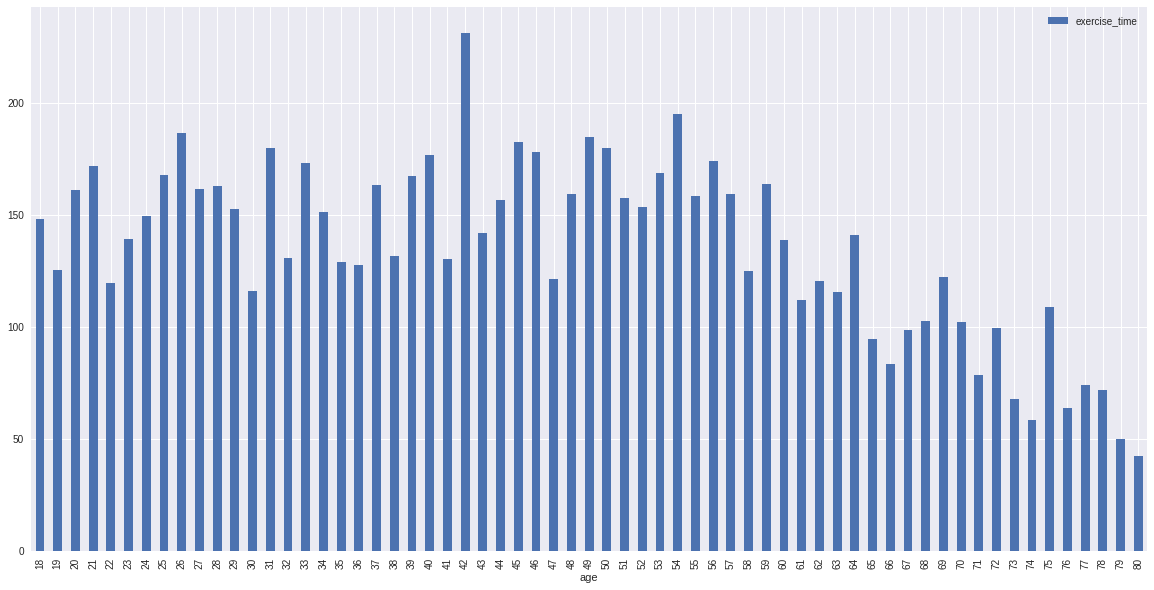

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

pd.pivot_table(persons_df,values='exercise_time',
               index='age').plot.bar()

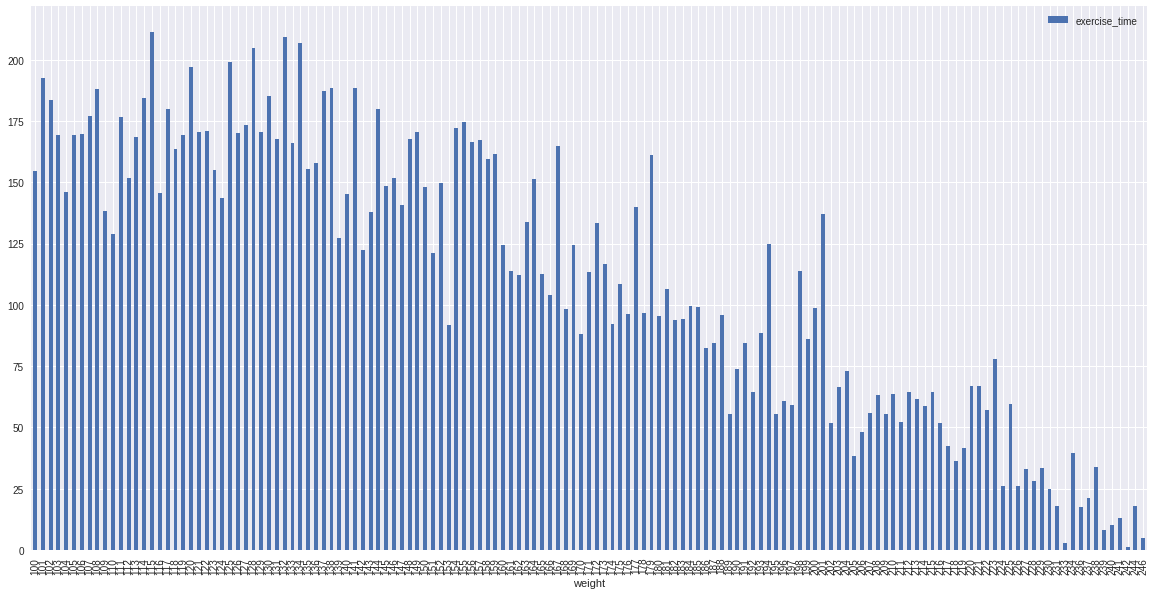

In [4]:
pd.pivot_table(persons_df,values='exercise_time',
               index='weight').plot.bar()

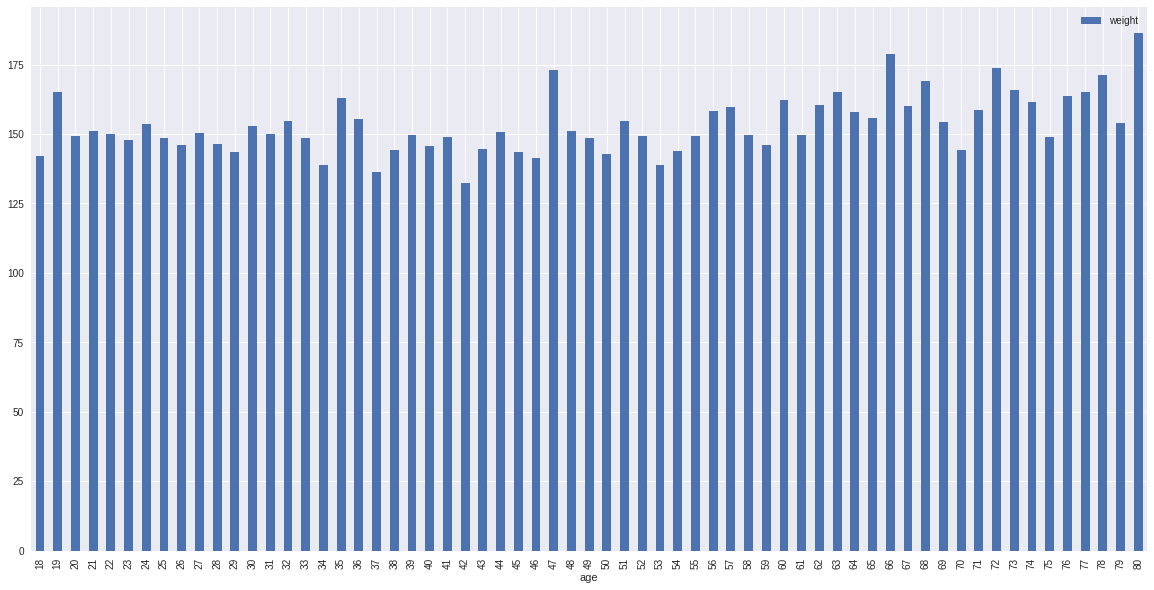

In [5]:
pd.pivot_table(persons_df,values='weight',
               index='age').plot.bar()

In [7]:
tempdf = persons_df[persons_df['age']  < 59]
print ('Average exercise time for those with age < 59:', tempdf['exercise_time'].mean())
tempdf = persons_df[persons_df['age']  > 76]
print ('Average exercise time for those with age > 76:', tempdf['exercise_time'].mean())
tempdf = persons_df[persons_df['weight']  < 160]
print ('Average exercise time for those with weight < 160:', tempdf['exercise_time'].mean())
tempdf = persons_df[persons_df['weight']  > 225]
print ('Average exercise time for those with weight > 225:', tempdf['exercise_time'].mean())

Average exercise time for those with age < 59: 154.4505076142132
Average exercise time for those with age > 76: 57.622950819672134
Average exercise time for those with weight < 160: 166.32823365785814
Average exercise time for those with weight > 225: 22.3125


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

 Three integers: age, weight and exercise time. Actually there's a fourth (col1), but it's
 an index that I dropped. The period (daily, weekly or monthly) for exercise time is not defined.
 I make the assumption that weight is in lbs, and exercise time is in minutes.

2.  What are the relationships between the variables?

 I tried paying around with binning and grouping and crosstabbing, but gave up when I
 wasn't getting anywhere. Once I started graphing the stuff, I saw what appear to me
 to be patterns emerge:
 
 2.1. After around age 58, exercise time goes down fairly dramatically in a pretty much linear fashion,
      to the point where those 77 and older exercise about a third as much as those 58 and younger.
      Those 58 and younger exercise, with some variance, around 154 minutes.
      
 2.2. There is a dramatic dropoff in exercise time once weight starts to exceed 159 lbs, also linear. Up to this point, again with some variance, people exercise around 166 minutes. Those over 225 lbs exercise around 22 minutes - with a great deal of variance.
      
 2.3. There appears to be no discernible realtionship between age and weight.
 
3.  Which relationships are "real", and which spurious?

 Not sure if this is what you're looking for, but as stated previously in point 2.3, there is little relationship between age and weight. This is borne out by a correlation value of 0.144168 - close to zero. As stated in points 2.1 and 2.2, there is - after a certain point - a "real" relationship between both age and exercise time, and weight and exercise time. Prior to these "certain points", there is no relationship between these.
 
==>> **NOTE:** I'm making these statements for THIS set of data only. What relationship this data has with reality I do not know.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)